<a href="https://colab.research.google.com/github/csun0602/Che-Sun-Data-analysis-Projects/blob/main/Che_Sun_Netflix_Movie_Data_Analysis_%26_Recommendation_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Spark Moive Recommendation**
In this notebook, we will use an Alternating Least Squares (ALS) algorithm with Spark APIs to predict the ratings for the movies in [MovieLens small dataset](https://grouplens.org/datasets/movielens/latest/)

**Netflix Movie Data Analysis & Recommendation System**


This project will build a recommendation system for big data. Netflix movie rating data are used to build the recommendation system by machine learning algorithm to system implementation. We will use Spark machine learning pipeline building and collaborative filtering model automatically tuning, and apply the built model on Netflix movie rating data.

### Setup and Data Loading

In [ ]:
# Spark setup
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://apache.mirrors.hoobly.com/spark/spark-2.4.6/spark-2.4.6-bin-hadoop2.7.tgz
!tar xf spark-2.4.6-bin-hadoop2.7.tgz
!pip install -q findspark
!pip install py4j

!export JAVA_HOME=$(/usr/lib/jvm/java-8-openjdk-amd64 -v 1.8)
! echo $JAVA_HOME
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.6-bin-hadoop2.7"
import findspark
findspark.init("spark-2.4.6-bin-hadoop2.7")# SPARK_HOME

from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

/bin/bash: /usr/lib/jvm/java-8-openjdk-amd64: Is a directory



In [ ]:
spark.version

'2.4.6'

In [ ]:
# load packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
import os
os.environ["PYSPARK_PYTHON"] = "python3"

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .appName("moive analysis") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()
spark.conf.set("spark.sql.broadcastTimeout",  36000)

In [ ]:
# unzip the training data files to colab data cloud
# !unzip ./drive/My\ Drive/Colab\ Notebooks/Movie\ Rating/ml\-latest.zip -d /content
# location="/content/ml-latest/"
location="/content/drive/My Drive/Colab Notebooks/Movie Rating/ml-latest-small/"

In [ ]:
movies_df = spark.read.load(location+"movies.csv", format='csv', header = True)
ratings_df = spark.read.load(location+"ratings.csv", format='csv', header = True)
links_df = spark.read.load(location+"links.csv", format='csv', header = True)
tags_df = spark.read.load(location+"tags.csv", format='csv', header = True)

In [ ]:
movies_df.show(5)

+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Adventure|Animati...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
|      4|Waiting to Exhale...|Comedy|Drama|Romance|
|      5|Father of the Bri...|              Comedy|
+-------+--------------------+--------------------+
only showing top 5 rows



In [ ]:
ratings_df.show(5)

+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     1|      1|   4.0|964982703|
|     1|      3|   4.0|964981247|
|     1|      6|   4.0|964982224|
|     1|     47|   5.0|964983815|
|     1|     50|   5.0|964982931|
+------+-------+------+---------+
only showing top 5 rows



In [ ]:
links_df.show(5)

+-------+-------+------+
|movieId| imdbId|tmdbId|
+-------+-------+------+
|      1|0114709|   862|
|      2|0113497|  8844|
|      3|0113228| 15602|
|      4|0114885| 31357|
|      5|0113041| 11862|
+-------+-------+------+
only showing top 5 rows



In [ ]:
tags_df.show(5)

+------+-------+---------------+----------+
|userId|movieId|            tag| timestamp|
+------+-------+---------------+----------+
|     2|  60756|          funny|1445714994|
|     2|  60756|Highly quotable|1445714996|
|     2|  60756|   will ferrell|1445714992|
|     2|  89774|   Boxing story|1445715207|
|     2|  89774|            MMA|1445715200|
+------+-------+---------------+----------+
only showing top 5 rows



In [ ]:
tmp1 = ratings_df.groupBy("userID").count().agg({'count':'min'}).toPandas()
tmp2 = ratings_df.groupBy("movieId").count().agg({'count':'min'}).toPandas()
print('For the users that rated movies and the movies that were rated:')
print('Minimum number of ratings per user is {}'.format(tmp1.iloc[0,0]))
print('Minimum number of ratings per movie is {}'.format(tmp2.iloc[0,0]))

For the users that rated movies and the movies that were rated:
Minimum number of ratings per user is 20
Minimum number of ratings per movie is 1


In [ ]:
tmp3 = ratings_df.groupBy("movieId").count().where('count=1').count()
tmp4 = ratings_df.select('movieId').distinct().count()
print('{} out of {} movies are rated by only one user'.format(tmp3, tmp4))

3446 out of 9724 movies are rated by only one user


### Part 1: Spark SQL and OLAP

In [ ]:
movies_df.registerTempTable("movies")
ratings_df.registerTempTable("ratings")
links_df.registerTempTable("links")
tags_df.registerTempTable("tags")

#### Q1: The number of Users

In [ ]:
# all users should be computed by both ratings and tags
# in case some users leave raings but no tag while some users leave tags but no rating
nuser=spark.sql('SELECT COUNT(DISTINCT userId) ' +\
                'FROM (' +\
	                'SELECT DISTINCT userId ' +\
	                'FROM ratings ' +\
	                'UNION ' +\
	                'SELECT DISTINCT userId ' +\
	                'FROM tags' +\
                ')').toPandas()
print('Total number of users is ',nuser.iloc[0,0])

Total number of users is  610


#### Q2: The number of Movies

In [ ]:
# the table movie should have all the movie records
nmovie=spark.sql('select count(distinct movieId) from movies').toPandas()
print('Total number of movies is ',nmovie.iloc[0,0])

Total number of movies is  9742


In [ ]:
# in case there are missing records in table movie
nmovie=spark.sql('SELECT COUNT(DISTINCT movieId) ' +\
                 'FROM ( ' +\
                    'SELECT DISTINCT movieId ' +\
                    'FROM movies ' +\
                    'UNION ' +\
                    'SELECT DISTINCT movieId ' +\
                    'FROM ratings ' +\
                    'UNION ' +\
                    'SELECT DISTINCT movieId ' +\
                    'FROM links ' +\
                    'UNION ' +\
                    'SELECT DISTINCT movieId ' +\
                    'FROM tags' +\
                 ')').toPandas()
print('Total number of movies is ',nmovie.iloc[0,0])

Total number of movies is  9742


#### Q3: How many movies are rated by users? List movies not rated before

In [ ]:
# number of movies rated
nrated=spark.sql('SELECT COUNT(DISTINCT a.movieId) ' +\
                 'FROM movies a ' +\
                  'JOIN ratings b ON a.movieId = b.movieId').toPandas()
print('Total number of movies that are rated by users is ',nrated.iloc[0,0])

Total number of movies that are rated by users is  9724


In [ ]:
# movies that have not been rated before: 50 movies as an example
unrated_list=spark.sql('SELECT * ' +\
                       'FROM movies ' +\
                       'WHERE movieId NOT IN ( ' +\
                        'SELECT movieId ' +\
                        'FROM ratings ' +\
                       ') ' +\
                       'LIMIT 50')
print('50 movies that have not been rated by users:')
unrated_list.show()

50 movies that have not been rated by users:
+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|   1076|Innocents, The (1...|Drama|Horror|Thri...|
|   2939|      Niagara (1953)|      Drama|Thriller|
|   3338|For All Mankind (...|         Documentary|
|   3456|Color of Paradise...|               Drama|
|   4194|I Know Where I'm ...|   Drama|Romance|War|
|   5721|  Chosen, The (1981)|               Drama|
|   6668|Road Home, The (W...|       Drama|Romance|
|   6849|      Scrooge (1970)|Drama|Fantasy|Mus...|
|   7020|        Proof (1991)|Comedy|Drama|Romance|
|   7792|Parallax View, Th...|            Thriller|
|   8765|This Gun for Hire...|Crime|Film-Noir|T...|
|  25855|Roaring Twenties,...|Crime|Drama|Thriller|
|  26085|Mutiny on the Bou...|Adventure|Drama|R...|
|  30892|In the Realms of ...|Animation|Documen...|
|  32160|Twentieth Century...|              Comedy|
|  32371|Call North

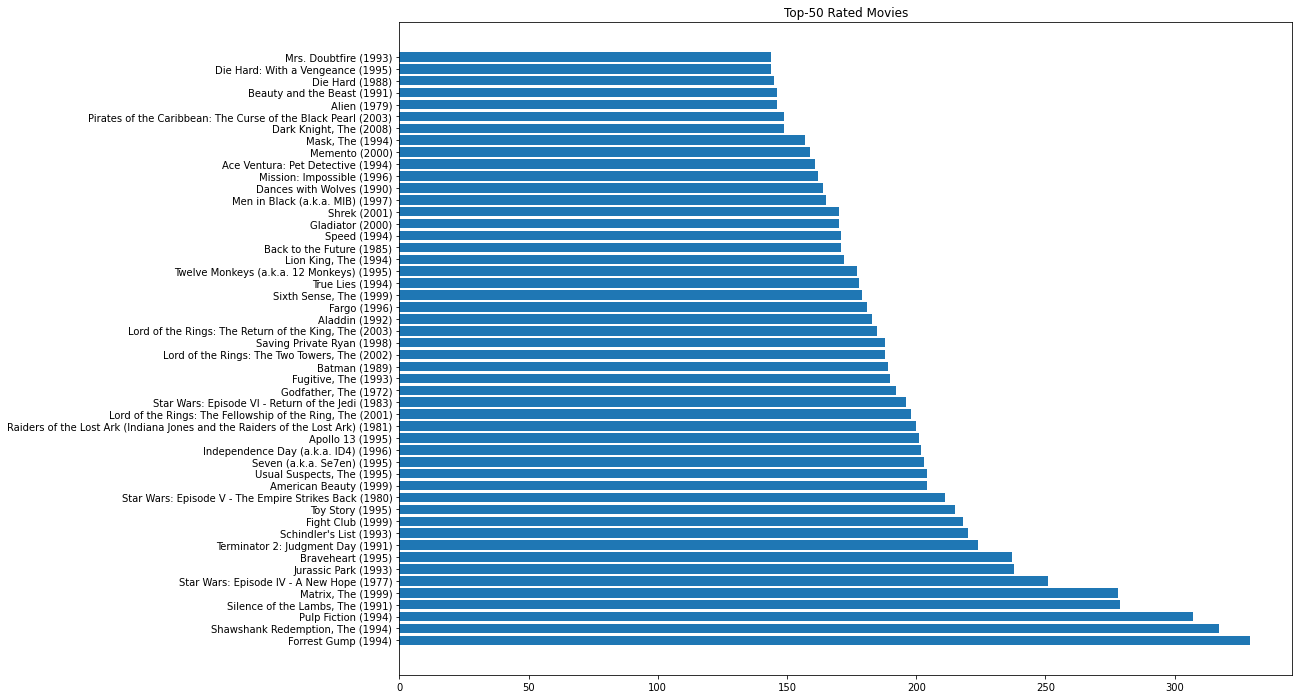

In [ ]:
# bar chart to view top 50 number of ratings per movie
rating_per_movie=spark.sql('SELECT title, SUM(rated) AS count ' +\
                           'FROM ( ' +\
                            'SELECT a.title ' +\
                              ', CASE  ' +\
                                  'WHEN rating IS NULL THEN 0 ' +\
                                  'ELSE 1 ' +\
                                'END AS rated ' +\
                            'FROM movies a ' +\
                              'LEFT JOIN ratings b ON a.movieId = b.movieId ' +\
                           ') ' +\
                           'GROUP BY 1 ' +\
                           'ORDER BY 2 DESC ' +\
                           'LIMIT 50')
plt.figure(figsize=[16,12])
plt.barh(y='title',width='count',data=rating_per_movie.toPandas())
plt.title('Top-50 Rated Movies')
plt.show()

#### Q4: List Movie Genres

In [ ]:
genres_list=spark.sql('select genres from movies').toPandas()
spark.sql('select distinct genres from movies').show()

+--------------------+
|              genres|
+--------------------+
|Comedy|Horror|Thr...|
|Adventure|Sci-Fi|...|
|Action|Adventure|...|
| Action|Drama|Horror|
|Action|Animation|...|
|Animation|Childre...|
|Action|Adventure|...|
|    Adventure|Sci-Fi|
|Documentary|Music...|
|Adventure|Childre...|
| Adventure|Animation|
| Musical|Romance|War|
|Action|Adventure|...|
|Adventure|Childre...|
|Comedy|Crime|Horr...|
|Crime|Drama|Fanta...|
|Comedy|Mystery|Th...|
|   Adventure|Fantasy|
|Horror|Romance|Sc...|
|Drama|Film-Noir|R...|
+--------------------+
only showing top 20 rows



In [ ]:
# separate genres by SQL
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType,StringType
genre_sep=udf(lambda x: x.split('|'),ArrayType(StringType()))
spark.udf.register('genre_sep',genre_sep)
spark.sql('SELECT DISTINCT genres_list ' +\
          'FROM movies  ' +\
          'LATERAL VIEW EXPLODE(genre_sep(genres)) AS genres_list ' +\
          'ORDER BY 1').show()

+------------------+
|       genres_list|
+------------------+
|(no genres listed)|
|            Action|
|         Adventure|
|         Animation|
|          Children|
|            Comedy|
|             Crime|
|       Documentary|
|             Drama|
|           Fantasy|
|         Film-Noir|
|            Horror|
|              IMAX|
|           Musical|
|           Mystery|
|           Romance|
|            Sci-Fi|
|          Thriller|
|               War|
|           Western|
+------------------+



In [ ]:
# separate genres by one-hot encoding
genres_list_onehot=genres_list['genres'].str.get_dummies(sep='|').astype(np.int64)
print(pd.DataFrame(genres_list_onehot.columns,columns=['genres_list']))

           genres_list
0   (no genres listed)
1               Action
2            Adventure
3            Animation
4             Children
5               Comedy
6                Crime
7          Documentary
8                Drama
9              Fantasy
10           Film-Noir
11              Horror
12                IMAX
13             Musical
14             Mystery
15             Romance
16              Sci-Fi
17            Thriller
18                 War
19             Western


In [ ]:
# separate genres manually
genres_list_set=set()
for i in genres_list['genres']:
  for j in i.split('|'):
    genres_list_set.add(j)
genres_list_set=sorted(list(genres_list_set))
print(pd.DataFrame(genres_list_set,columns=['genres_list']))

           genres_list
0   (no genres listed)
1               Action
2            Adventure
3            Animation
4             Children
5               Comedy
6                Crime
7          Documentary
8                Drama
9              Fantasy
10           Film-Noir
11              Horror
12                IMAX
13             Musical
14             Mystery
15             Romance
16              Sci-Fi
17            Thriller
18                 War
19             Western


#### Q5: Movie for Each Category

In [ ]:
# by sql
movie_by_genre=spark.sql('SELECT title,category ' +\
                         'FROM movies ' +\
                         'LATERAL VIEW EXPLODE(genre_sep(genres)) AS category')
movie_by_genre.createOrReplaceTempView('movie_by_genre')
str_comb=lambda x: ','.join(sorted(x))
spark.udf.register('str_comb',str_comb)
spark.sql('SELECT category, COUNT(*) AS number ' +\
          'FROM movie_by_genre  ' +\
          'GROUP BY category  ' +\
          'ORDER BY 2 DESC').show()
spark.sql('SELECT category, str_comb(collect_set(title)) AS list_of_movies ' +\
          'FROM movie_by_genre  ' +\
          'GROUP BY category  ' +\
          'ORDER BY 1').show()

+------------------+------+
|          category|number|
+------------------+------+
|             Drama|  4361|
|            Comedy|  3756|
|          Thriller|  1894|
|            Action|  1828|
|           Romance|  1596|
|         Adventure|  1263|
|             Crime|  1199|
|            Sci-Fi|   980|
|            Horror|   978|
|           Fantasy|   779|
|          Children|   664|
|         Animation|   611|
|           Mystery|   573|
|       Documentary|   440|
|               War|   382|
|           Musical|   334|
|           Western|   167|
|              IMAX|   158|
|         Film-Noir|    87|
|(no genres listed)|    34|
+------------------+------+

+------------------+--------------------+
|          category|      list_of_movies|
+------------------+--------------------+
|(no genres listed)|A Christmas Story...|
|            Action|'71 (2014),'Hellb...|
|         Adventure|'Hellboy': The Se...|
|         Animation|101 Dalmatians (O...|
|          Children|*batteries no

In [ ]:
# by one hot encoding
movies_df0=pd.concat([movies_df.select('movieId','title').toPandas(),genres_list_onehot],axis=1)
cat_count=movies_df0.iloc[:,2:].sum().sort_values(ascending=False).reset_index()
cat_count.columns=['category','number']
cat_count

,category,number
0,Drama,4361
1,Comedy,3756
2,Thriller,1894
3,Action,1828
4,Romance,1596
5,Adventure,1263
6,Crime,1199
7,Sci-Fi,980
8,Horror,978
9,Fantasy,779


In [ ]:
cat_list=pd.DataFrame(columns=['category','list_of_movies'])
for i in range(2,movies_df0.shape[1]):
  cat_list.loc[i-2]=[movies_df0.columns[i],\
                   ','.join(sorted(movies_df0.loc[movies_df0.iloc[:,i]==1]['title']))]
cat_list

,category,list_of_movies
0,(no genres listed),"A Christmas Story Live! (2017),A Cosmic Christ..."
1,Action,"'71 (2014),'Hellboy': The Seeds of Creation (2..."
2,Adventure,"'Hellboy': The Seeds of Creation (2004),10,000..."
3,Animation,101 Dalmatians (One Hundred and One Dalmatians...
4,Children,"*batteries not included (1987),101 Dalmatians ..."
5,Comedy,"'Hellboy': The Seeds of Creation (2004),'burbs..."
6,Crime,"00 Schneider - Jagd auf Nihil Baxter (1994),10..."
7,Documentary,"'Hellboy': The Seeds of Creation (2004),11th H..."
8,Drama,"""11'09""""01 - September 11 (2002)"",'71 (2014),'..."
9,Fantasy,"'Hellboy': The Seeds of Creation (2004),*batte..."


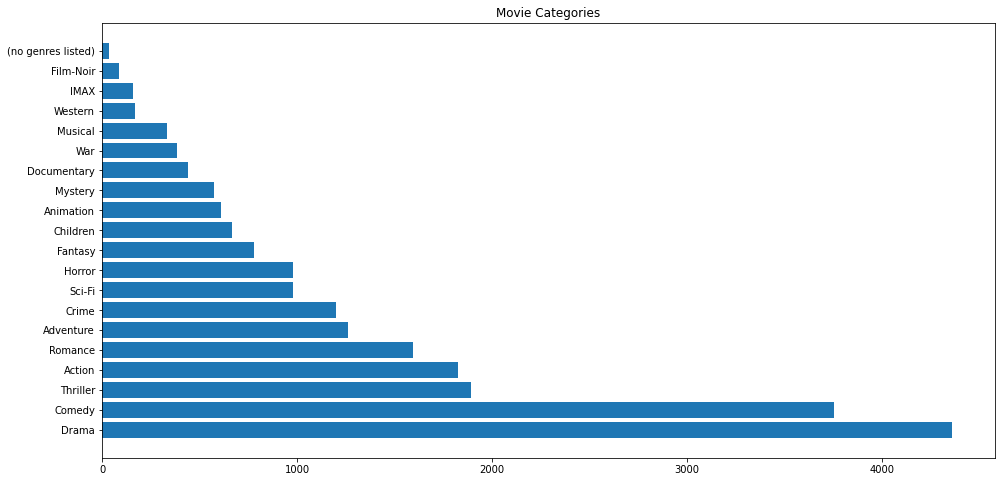

In [ ]:
# bar chart
plt.figure(figsize=[16,8])
plt.barh(y='category',width='number',data=cat_count)
plt.title('Movie Categories')
plt.show()

### Part2: Spark ALS based approach for training model
We will use an Spark ML to predict the ratings, so let's reload "ratings.csv" using sc.textFile and then convert it to the form of (user, item, rating) tuples.

#### Data Preprocessing

In [ ]:
ratings_df.show()

+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     1|      1|   4.0|964982703|
|     1|      3|   4.0|964981247|
|     1|      6|   4.0|964982224|
|     1|     47|   5.0|964983815|
|     1|     50|   5.0|964982931|
|     1|     70|   3.0|964982400|
|     1|    101|   5.0|964980868|
|     1|    110|   4.0|964982176|
|     1|    151|   5.0|964984041|
|     1|    157|   5.0|964984100|
|     1|    163|   5.0|964983650|
|     1|    216|   5.0|964981208|
|     1|    223|   3.0|964980985|
|     1|    231|   5.0|964981179|
|     1|    235|   4.0|964980908|
|     1|    260|   5.0|964981680|
|     1|    296|   3.0|964982967|
|     1|    316|   3.0|964982310|
|     1|    333|   5.0|964981179|
|     1|    349|   4.0|964982563|
+------+-------+------+---------+
only showing top 20 rows



In [ ]:
movie_ratings=ratings_df.drop('timestamp')

In [ ]:
# Data type convert
from pyspark.sql.types import IntegerType, FloatType
movie_ratings = movie_ratings.withColumn("userId", movie_ratings["userId"].cast(IntegerType()))
movie_ratings = movie_ratings.withColumn("movieId", movie_ratings["movieId"].cast(IntegerType()))
movie_ratings = movie_ratings.withColumn("rating", movie_ratings["rating"].cast(FloatType()))

In [ ]:
movie_ratings.show()

+------+-------+------+
|userId|movieId|rating|
+------+-------+------+
|     1|      1|   4.0|
|     1|      3|   4.0|
|     1|      6|   4.0|
|     1|     47|   5.0|
|     1|     50|   5.0|
|     1|     70|   3.0|
|     1|    101|   5.0|
|     1|    110|   4.0|
|     1|    151|   5.0|
|     1|    157|   5.0|
|     1|    163|   5.0|
|     1|    216|   5.0|
|     1|    223|   3.0|
|     1|    231|   5.0|
|     1|    235|   4.0|
|     1|    260|   5.0|
|     1|    296|   3.0|
|     1|    316|   3.0|
|     1|    333|   5.0|
|     1|    349|   4.0|
+------+-------+------+
only showing top 20 rows



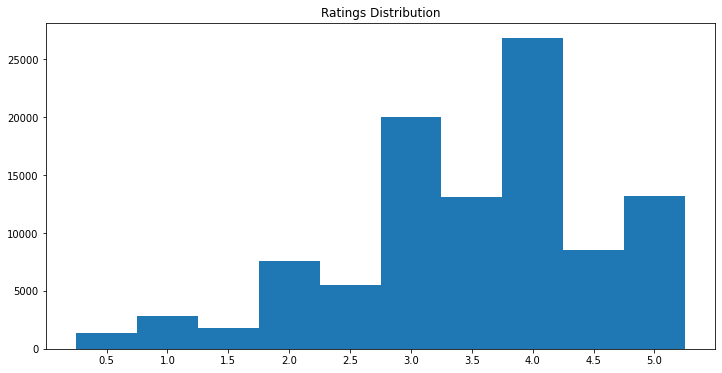

In [ ]:
# bar chart of ratings
rating_count=movie_ratings.select('rating').groupBy('rating').count().toPandas()
plt.figure(figsize=[12,6])
plt.bar(x='rating',height='count',data=rating_count,width=0.5)
plt.title('Ratings Distribution')
plt.xticks(np.arange(0.5,5.5,0.5))
plt.show()

#### ALS Model Selection and Evaluation
With the ALS model, we can use a grid search to find the optimal hyperparameters.

In [ ]:
# import package
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import CrossValidator,ParamGridBuilder

In [ ]:
# Create test and train set
(training,test) = movie_ratings.randomSplit([0.8,0.2])

In [ ]:
# Create ALS model
model_als = ALS(userCol="userId", itemCol="movieId", ratingCol="rating", coldStartStrategy="drop", seed=12345)

In [ ]:
# Define evaluator as RMSE
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")

In [ ]:
# Tune model using ParamGridBuilder
params = ParamGridBuilder()\
            .addGrid(model_als.maxIter, [3, 5, 10])\
            .addGrid(model_als.regParam, [0.1, 0.01, 0.001])\
            .addGrid(model_als.rank, [5, 10, 15, 20, 25])\
            .addGrid(model_als.alpha, [0.1, 0.01, 0.001])\
            .build()

# Build Cross validation
cv_creator=CrossValidator(estimator=model_als,estimatorParamMaps=params,evaluator=evaluator,numFolds=4,seed=12345)

#Fit ALS model to training data
cv_model=cv_creator.fit(training)

In [ ]:
best_model=cv_model.bestModel
best_params=cv_model.getEstimatorParamMaps()[np.argmin(cv_model.avgMetrics)]
print('Best ALS model parameters by CV:')
for i,j in best_params.items():
  print('-> '+i.name+': '+str(j))

Best ALS model parameters by CV:
-> maxIter: 10
-> regParam: 0.1
-> rank: 5
-> alpha: 0.1


In [ ]:
#Extract best model from the tuning exercise using ParamGridBuilder
prediction_train=cv_model.transform(training)
rmse_train = evaluator.evaluate(prediction_train)
print("Root-mean-square error for training data is " + str(rmse_train))

Root-mean-square error for training data is 0.6413349309194337


#### Model testing
And finally, make a prediction and check the testing error.

In [ ]:
#Generate predictions and evaluate using RMSE
prediction_test = best_model.transform(test)
rmse_test = evaluator.evaluate(prediction_test)
print("Root-mean-square error for testing data is " + str(rmse_test))

Root-mean-square error for testing data is 0.8840108088036324


In [ ]:
prediction_test.show()

+------+-------+------+----------+
|userId|movieId|rating|prediction|
+------+-------+------+----------+
|   372|    471|   3.0| 3.2278666|
|   182|    471|   4.5| 3.7144341|
|   474|    471|   3.0| 3.7856388|
|   500|    471|   1.0| 2.8237948|
|   176|    471|   5.0| 3.7838287|
|   171|    471|   3.0| 4.3478956|
|   287|    471|   4.5| 2.5647352|
|   541|    471|   3.0| 3.8739734|
|   132|   1088|   4.0| 2.8536036|
|   474|   1088|   3.5| 3.3035452|
|   554|   1088|   5.0|  4.590239|
|   387|   1088|   1.5|  2.761524|
|   381|   1088|   3.5| 3.7248476|
|   583|   1088|   3.5| 3.3533254|
|    10|   1088|   3.0|  3.128701|
|    42|   1088|   3.0| 3.4244099|
|   104|   1088|   3.0| 3.6357198|
|   268|   1238|   5.0|  3.410654|
|   425|   1342|   3.5| 1.9000343|
|   387|   1342|   3.0| 2.6661174|
+------+-------+------+----------+
only showing top 20 rows



#### Model apply and see the performance

In [ ]:
alldata=best_model.transform(movie_ratings)
rmse = evaluator.evaluate(alldata)
print ("RMSE = "+str(rmse))

RMSE = 0.6948416336187491


In [ ]:
alldata.registerTempTable("alldata")

In [ ]:
spark.sql("select * from alldata").show()

+------+-------+------+----------+
|userId|movieId|rating|prediction|
+------+-------+------+----------+
|   191|    148|   5.0|  4.931147|
|   133|    471|   4.0| 3.1237504|
|   597|    471|   2.0|   3.67073|
|   385|    471|   4.0|  3.196448|
|   436|    471|   3.0| 3.5980487|
|   602|    471|   4.0| 3.7751944|
|    91|    471|   1.0|  3.118206|
|   409|    471|   3.0|  3.588822|
|   372|    471|   3.0| 3.2278666|
|   599|    471|   2.5| 2.8903582|
|   603|    471|   4.0| 3.2133949|
|   182|    471|   4.5| 3.7144341|
|   218|    471|   4.0| 3.3264654|
|   474|    471|   3.0| 3.7856388|
|   500|    471|   1.0| 2.8237948|
|    57|    471|   3.0| 3.5345447|
|   462|    471|   2.5| 3.0256515|
|   387|    471|   3.0|  3.269706|
|   610|    471|   4.0|  3.826982|
|   217|    471|   2.0| 3.0273292|
+------+-------+------+----------+
only showing top 20 rows



In [ ]:
spark.sql('SELECT * ' +\
          'FROM movies ' +\
	          'JOIN alldata ON movies.movieId = alldata.movieId').show()

+-------+--------------------+------+------+-------+------+----------+
|movieId|               title|genres|userId|movieId|rating|prediction|
+-------+--------------------+------+------+-------+------+----------+
|    148|Awfully Big Adven...| Drama|   191|    148|   5.0|  4.931147|
|    471|Hudsucker Proxy, ...|Comedy|   133|    471|   4.0| 3.1237504|
|    471|Hudsucker Proxy, ...|Comedy|   597|    471|   2.0|   3.67073|
|    471|Hudsucker Proxy, ...|Comedy|   385|    471|   4.0|  3.196448|
|    471|Hudsucker Proxy, ...|Comedy|   436|    471|   3.0| 3.5980487|
|    471|Hudsucker Proxy, ...|Comedy|   602|    471|   4.0| 3.7751944|
|    471|Hudsucker Proxy, ...|Comedy|    91|    471|   1.0|  3.118206|
|    471|Hudsucker Proxy, ...|Comedy|   409|    471|   3.0|  3.588822|
|    471|Hudsucker Proxy, ...|Comedy|   372|    471|   3.0| 3.2278666|
|    471|Hudsucker Proxy, ...|Comedy|   599|    471|   2.5| 2.8903582|
|    471|Hudsucker Proxy, ...|Comedy|   603|    471|   4.0| 3.2133949|
|    4

### Recommend moive to users with id: 575, 232.
you can choose some users to recommend the moives

In [ ]:
# define a function to package the recommendation
def topKRecommend(k,id,model):
  '''
  k: the number of movies to recommend
  id: the id of the user to give recommendations
  model: the trained model for recommendation
  '''
  # the table for all top10 recommendations
  all_recommd=model.recommendForAllUsers(k)
  user_recommd=all_recommd.where(all_recommd.userId==id).toPandas()
  if user_recommd.shape[0]==0:
    print('No user with id '+str(id)+' is found in the data.')
    return None
  user_recommd=user_recommd.iloc[0,1]
  user_recommd=pd.DataFrame(user_recommd,columns=['movieId','predicted_ratings'])
  temp=None
  for i in user_recommd['movieId']:
    if not temp:
      temp=movies_df.where(movies_df.movieId==str(i))
    else:
      temp=temp.union(movies_df.where(movies_df.movieId==str(i)))
  out=pd.concat([temp.toPandas(),user_recommd['predicted_ratings']],axis=1)
  out.index=range(1,k+1)
  return out

In [ ]:
# top 10 for user 575
topKRecommend(10,575,best_model)

,movieId,title,genres,predicted_ratings
1,87234,Submarine (2010),Comedy|Drama|Romance,5.363260
2,96004,Dragon Ball Z: The History of Trunks (Doragon ...,Action|Adventure|Animation,5.329022
3,3379,On the Beach (1959),Drama,5.329022
4,6818,Come and See (Idi i smotri) (1985),Drama|War,5.222176
5,60943,Frozen River (2008),Drama,5.209704
6,59018,"Visitor, The (2007)",Drama|Romance,5.209704
7,69524,Raiders of the Lost Ark: The Adaptation (1989),Action|Adventure|Thriller,5.185848
8,3022,"General, The (1926)",Comedy|War,5.179244
9,1232,Stalker (1979),Drama|Mystery|Sci-Fi,5.169555
10,27611,Battlestar Galactica (2003),Drama|Sci-Fi|War,5.154844


In [ ]:
# top 15 for user 232
topKRecommend(15,232,best_model)

,movieId,title,genres,predicted_ratings
1,87234,Submarine (2010),Comedy|Drama|Romance,5.519401
2,5607,"Son of the Bride (Hijo de la novia, El) (2001)",Comedy|Drama,4.893378
3,25906,Mr. Skeffington (1944),Drama|Romance,4.833454
4,93008,"Very Potter Sequel, A (2010)",Comedy|Musical,4.833454
5,77846,12 Angry Men (1997),Crime|Drama,4.833454
6,7071,"Woman Under the Influence, A (1974)",Drama,4.747414
7,138966,Nasu: Summer in Andalusia (2003),Animation,4.747414
8,184245,De platte jungle (1978),Documentary,4.747414
9,26928,"Summer's Tale, A (Conte d'été) (1996)",Comedy|Drama|Romance,4.747414
10,84273,Zeitgeist: Moving Forward (2011),Documentary,4.747414


In [ ]:
# top 5 for user 1
topKRecommend(5,1,best_model)

,movieId,title,genres,predicted_ratings
1,87234,Submarine (2010),Comedy|Drama|Romance,6.406131
2,96004,Dragon Ball Z: The History of Trunks (Doragon ...,Action|Adventure|Animation,6.253650
3,3379,On the Beach (1959),Drama,6.253650
4,5607,"Son of the Bride (Hijo de la novia, El) (2001)",Comedy|Drama,6.081218
5,69524,Raiders of the Lost Ark: The Adaptation (1989),Action|Adventure|Thriller,5.979123


### Find the similar moives for moive with id: 463, 471
You can find the similar moives based on the ALS results

In [ ]:
# access the movie factor matrix
movie_factors=best_model.itemFactors
movie_factors.printSchema()
comd=["movie_factors.selectExpr('id as movieId',"]
for i in range(best_model.rank):
  if i<best_model.rank-1:
    comd.append("'features["+str(i)+"] as feature"+str(i)+"',")
  else:
    comd.append("'features["+str(i)+"] as feature"+str(i)+"'")
comd.append(')')
movie_factors=eval(''.join(comd))
movie_factors.createOrReplaceTempView('movie_factors')
movie_factors.show()

root
 |-- id: integer (nullable = false)
 |-- features: array (nullable = true)
 |    |-- element: float (containsNull = false)

+-------+------------+-----------+------------+-----------+------------+
|movieId|    feature0|   feature1|    feature2|   feature3|    feature4|
+-------+------------+-----------+------------+-----------+------------+
|     10|  0.73430854| 0.34665388|  -0.4754449| -1.7185824| -0.19925913|
|     20|   1.1877204|  -0.814182| -0.64112663|-0.97034216| -0.14531042|
|     30|   1.0854285| 0.19992247|  -0.9369189|-0.49996373|   1.5783162|
|     40|-0.041639097|  1.1786628| -0.13801299| -1.6928382|  0.29482466|
|     50|   1.3242272| 0.11620303| -0.74948174| -1.7951143|  0.33930174|
|     60|   0.1380839|-0.33747497| -0.19962206| -1.8852065| 0.006399505|
|     70|    1.039271|-0.11352531| -0.81217563| -1.4581811| -0.50512093|
|     80|    1.266465|  0.2800456| -0.66434234|  -1.138831|   0.8855084|
|    100|  0.15695767|  0.2157823| -0.26024452| -1.5447004|   0.4002

In [ ]:
# method 1: Euclidean distance based similarity
# the smaller the euclidean distance between the factors, the similar the movies
# this similarity considers the actual strength,
# e.g. movie 1 with factor [1,2,3] and movie 2 with factor [2,4,6] are considered not similar enough
def dist_similar(k,mid):
  '''
  k: number of similar movies to find
  mid: id of the movie to find similarities
  '''
  movie_info=spark.sql('select * from movie_factors where movieId='+str(mid)).toPandas()
  if movie_info.shape[0]<=0:
    print('No movie with id '+str(mid)+' is found in the data.')
    return None, None
  temp=['select movieId,']
  for i in range(best_model.rank):
    val=movie_info.iloc[0,i+1]
    if val>0:
      comd='feature'+str(i)+'-'+str(val)
    else:
      comd='feature'+str(i)+'+'+str(-val)
    if i<best_model.rank-1:
      temp.append('('+comd+')*('+comd+') as sd'+str(i)+',')
    else:
      temp.append('('+comd+')*('+comd+') as sd'+str(i))
  temp.append('from movie_factors where movieId!='+str(mid))
  ssd=spark.sql(' '.join(temp))
  ssd=ssd.selectExpr('movieId','sd0+sd1+sd2+sd2+sd4 as ssd').orderBy('ssd').limit(k).toPandas()
  out=None
  for i in ssd['movieId']:
    if not out:
      out=movies_df.where(movies_df.movieId==str(i))
    else:
      out=out.union(movies_df.where(movies_df.movieId==str(i)))
  out=out.toPandas()
  out.index=range(1,k+1)
  return out, ssd

In [ ]:
# method 2: cosine similarity
# the larger the cosine value, the smaller the two feature vectors' angle, the similar the movies
# this similarity considers the direction only,
# e.g. movie 1 with factor [1,2,3] and movie 2 with factor [2,4,6] are considered the same
def cos_similar(k,mid):
  '''
  k: number of similar movies to find
  mid: id of the movie to find similarities
  '''
  movie_info=spark.sql('select * from movie_factors where movieId='+str(mid)).toPandas()
  if movie_info.shape[0]<=0:
    print('No movie with id '+str(mid)+' is found in the data.')
    return None, None
  norm_m=sum(movie_info.iloc[0,1:].values**2)**0.5
  temp=['select movieId,']
  norm_str=['sqrt(']
  for i in range(best_model.rank):
    comd='feature'+str(i)+'*'+str(movie_info.iloc[0,i+1])
    temp.append(comd+' as inner'+str(i)+',')
    if i<best_model.rank-1:
      norm_str.append('feature'+str(i)+'*feature'+str(i)+'+')
    else:
      norm_str.append('feature'+str(i)+'*feature'+str(i))
  norm_str.append(') as norm')
  temp.append(''.join(norm_str))
  temp.append(' from movie_factors where movieId!='+str(mid))
  inner=spark.sql(' '.join(temp))
  inner=inner.selectExpr('movieId',\
                         '(inner0+inner1+inner2+inner3+inner4)/norm/'+str(norm_m)+' as innerP').\
                         orderBy('innerP',ascending=False).limit(k).toPandas()
  out=None
  for i in inner['movieId']:
    if not out:
      out=movies_df.where(movies_df.movieId==str(i))
    else:
      out=out.union(movies_df.where(movies_df.movieId==str(i)))
  out=out.toPandas()
  out.index=range(1,k+1)
  return out, inner

In [ ]:
# movie id 463, method 1, top 10 similar
out11,ssd1=dist_similar(10,463)

No movie with id 463 is found in the data.


In [ ]:
# movie id 463, method 2, top 10 similar
out12,inner1=cos_similar(10,463)

No movie with id 463 is found in the data.


In [ ]:
# movie id 471, method 1, top 10 similar
out21,ssd2=dist_similar(10,471)
out21

,movieId,title,genres
1,5505,"Good Girl, The (2002)",Comedy|Drama
2,1647,Playing God (1997),Crime|Drama|Thriller
3,2043,Darby O'Gill and the Little People (1959),Adventure|Children|Fantasy
4,911,Charade (1963),Comedy|Crime|Mystery|Romance|Thriller
5,4361,Tootsie (1982),Comedy|Romance
6,2660,"Thing from Another World, The (1951)",Horror|Sci-Fi
7,7766,Throne of Blood (Kumonosu jô) (1957),Action|Drama|Thriller|War
8,249,Immortal Beloved (1994),Drama|Romance
9,134214,Youth (2015),Drama
10,30898,"Upside of Anger, The (2005)",Comedy|Drama|Romance


In [ ]:
# movie id 471, method 2, top 10 similar
out22,inner2=cos_similar(10,471)
out22

,movieId,title,genres
1,911,Charade (1963),Comedy|Crime|Mystery|Romance|Thriller
2,4361,Tootsie (1982),Comedy|Romance
3,249,Immortal Beloved (1994),Drama|Romance
4,7766,Throne of Blood (Kumonosu jô) (1957),Action|Drama|Thriller|War
5,69951,"Imaginarium of Doctor Parnassus, The (2009)",Drama|Fantasy
6,134214,Youth (2015),Drama
7,6461,"Unforgiven, The (1960)",Drama|Western
8,5505,"Good Girl, The (2002)",Comedy|Drama
9,44709,Akeelah and the Bee (2006),Drama
10,40583,Syriana (2005),Drama|Thriller


In [ ]:
# movie id 10, method 1, top 5 similar
out31,ssd3=dist_similar(5,10)
out31

,movieId,title,genres
1,5219,Resident Evil (2002),Action|Horror|Sci-Fi|Thriller
2,4174,Avalon (1990),Drama
3,2774,Better Than Chocolate (1999),Comedy|Romance
4,6769,Mambo Italiano (2003),Comedy
5,34321,Bad News Bears (2005),Children|Comedy


In [ ]:
# movie id 10, method 2, top 5 similar
out42,inner3=cos_similar(5,10)
out42

,movieId,title,genres
1,4886,"Monsters, Inc. (2001)",Adventure|Animation|Children|Comedy|Fantasy
2,112175,How to Train Your Dragon 2 (2014),Action|Adventure|Animation
3,2115,Indiana Jones and the Temple of Doom (1984),Action|Adventure|Fantasy
4,1495,Turbo: A Power Rangers Movie (1997),Action|Adventure|Children
5,2491,Simply Irresistible (1999),Comedy|Romance


### Overall Summary


#### Motivation:



As a website to watch movies, we will make more money if more customers are able to find their favorite films through our services, so a good recommendation system will be the key to our success. Based on this idea, I tried myself to build a simple recommendation system using the data from GroupLens (https://grouplens.org/datasets/movielens/latest/) to understand how a recommendation system is constructed. In this way, I will be prepared when I become a data scientist for a movie service company in the future.

#### Steps:

**Step 1.** Data exploration (EDA): obtain the general information about the data, including the total number of users, total number of movies and the list of unrated movies .etc; OLAP analysis to find the genres, all movie categories and number of movies in each category.

**Step 2.** Data preprocessing: keep only the userId, movieId and rating columns; change the data type from string to numeric; separate the data to 80% training and 20% testing.

**Step 3.** Model building: fit the alternative least square (ALS) model on the training data; select the hyper-parameters through grid search and 4-fold cross validation; evaluate the tuned model on testing data.

**Step 4.**Model application: apply the model on the whole rating data to see the performance; use the model to make recommendations to users with given userIds; use one of the model output: item factor to find similar movies for movies with given movieIds.



#### Output and conclusion:

 - The best model for ALS has the parameters to be: maxIter=10, regParam=0.1, rank=5, alpha=0.1. The rooted mean squared error (RMSE) on the testing data is 0.88 and on the whole dataset is 0.69.

 - As mentioned in the steps, the ALS model is not only able to provide recommendations, but also able to mine latent information, which is the latent variable in matrix factorization. This latent information is helpful that it can help us gain some deeper insight. In this project, this information was used to measure the difference between any two movies so that we are able to find similar movies .  